## Word2Vec

The TensorFlow library has made our lives easier by introducing multiple
predefined functions to be used in the implementation of word2vec
algorithms.


This notebook includes the implementation for both the
word2vec algos, skip-gram.

https://www.tensorflow.org/tutorials/word2vec

**Note:** The data used for our exercise is a compressed format of the
English Wikipedia dump made on March 3, 2006. It is available from the
following link: http://mattmahoney.net/dc/textdata.html.

**Importing the required packages**

In [1]:
"""Importing the required packages"""
import random
import collections
import math
import os
import zipfile
import time
import re 

import numpy as np
import tensorflow as tf

from matplotlib import pylab
%matplotlib inline

from six.moves import range
from six.moves.urllib.request import urlretrieve

from tensorflow.contrib.tensorboard.plugins import projector
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
from IPython.display import display, Math, Latex

**Download, Extract and Read File**

In [3]:
"""Make sure the dataset link is copied correctly"""

dataset_link = 'http://mattmahoney.net/dc/'
zip_file = 'text8.zip'

def data_download(zip_file):
    """Downloading the required file"""
    if not os.path.exists(zip_file):
        zip_file, _ = urlretrieve(dataset_link + zip_file, zip_file)
        print('File downloaded successfully!')
    return None

data_download(zip_file)

"""Extracting the dataset in separate folder"""
extracted_folder = 'dataset'

if not os.path.isdir(extracted_folder):
    with zipfile.ZipFile(zip_file) as zf:
        zf.extractall(extracted_folder)
        
with open('dataset/text8') as ft_ :
    full_text = ft_.read()        

**Save data into a variable**

In [4]:
with open('dataset/text8') as ft_ :
    full_text = ft_.read()

**Function to do the treatment of text punctuation**

As the input data has multiple punctuation and other symbols
across the text, the same are replaced with their respective tokens, with
the type of punctuation and symbol name in the token. This helps the
model to identify each of the punctuation and other symbols individually
and produce a vector. The function text_processing() performs this
operation. It takes the Wikipedia text data as input.

In [5]:
def text_processing(ft8_text):
    """Replacing punctuation marks with tokens"""
    ft8_text = ft8_text.lower()
    ft8_text = ft8_text.replace('.', ' <period> ')
    ft8_text = ft8_text.replace(',', ' <comma> ')
    ft8_text = ft8_text.replace('"', ' <quotation> ')
    ft8_text = ft8_text.replace(';', ' <semicolon> ')
    ft8_text = ft8_text.replace('!', ' <exclamation> ')
    ft8_text = ft8_text.replace('?', ' <question> ')
    ft8_text = ft8_text.replace('(', ' <paren_l> ')
    ft8_text = ft8_text.replace(')', ' <paren_r> ')
    ft8_text = ft8_text.replace('--', ' <hyphen> ')
    ft8_text = ft8_text.replace(':', ' <colon> ')
    ft8_text_tokens = ft8_text.split()
    
    return ft8_text_tokens

In [6]:
ft_tokens = text_processing(full_text)

**Selecting the words with frequency higher than a threshold**

To improve the quality of the vector representations produced, it is
recommended to remove the noise related to the words, i.e., words with a
frequency of less than 7 in the input dataset, as these words will not have
enough information to provide the context they are present in.
One can change this threshold by checking the distribution of the word
count and in the dataset. For convenience, we have taken it as 7 here.

In [7]:
"""Shortlisting words with frequency more than 7"""
wrd_freq_threshold = 7
word_cnt = collections.Counter(ft_tokens)
shortlisted_words = [w for w in ft_tokens if word_cnt[w] > wrd_freq_threshold ]

List the top words present in the dataset on the basis of their
frequency, as follows:

In [8]:
print(shortlisted_words[:15])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including']


Check the stats of the total words present in the dataset.

In [9]:
print("Total number of shortlisted words : ",len(shortlisted_words))
print("Unique number of shortlisted words : ",len(set(shortlisted_words)))

Total number of shortlisted words :  16616688
Unique number of shortlisted words :  53721


**Oder words by the frequency**

To process the unique words present in the corpus, we have made a
set of the words, followed by their frequency in the training dataset. The
following function creates a dictionary and converts words to integers
and, conversely, integers to words. The most frequent word is assigned the
least value, 0, and in similar fashion, numbers are assigned to other words.
Conversion of words to integers has been stored in a separate list.

In [10]:
"""The function creates a dictionary of the words present in dataset along with their frequency order"""
def dict_creation(shortlisted_words):
    counts = collections.Counter(shortlisted_words)
    vocabulary = sorted(counts, key=counts.get, reverse=True)
    rev_dictionary_ = {ii: word for ii, word in enumerate(vocabulary)}
    dictionary_ = {word: ii for ii, word in rev_dictionary_.items()}
    return dictionary_, rev_dictionary_

In [11]:
dictionary_, rev_dictionary_ = dict_creation(shortlisted_words)
words_cnt = [dictionary_[word] for word in shortlisted_words]

The variables created up to this point are common and could be used
in the implementation of the either of the word2vec models.

The next
subsections include the implementation of both architectures (**CBOW,skip-gram**).

## CBOW
The CBOW model considers the surrounding words and predicts the
center word. Therefore, the batch and label generation have been achieved
using the cbow_batch_creation() function, which assigns the target
word in the label_ variable and the surrounding words in the context in
the batch variable, when the desired word_window size is passed to the
function.


In [20]:
data_index = 0

def cbow_batch_creation(batch_length, word_window):
    """The function creates a batch with the list of the label words and list of their corresponding words in the context of
    the label word."""
    global data_index
    """Pulling out the centered label word, and its next word_window count of surrounding words
    word_window : window of words on either side of the center word
    relevant_words : length of the total words to be picked in a single batch, 
            including the center word and the word_window words on both sides
    Format :  [ word_window ... target ... word_window ] """
    relevant_words = 2 * word_window + 1 

    batch = np.ndarray(shape=(batch_length,relevant_words-1), dtype=np.int32)
    label_ = np.ndarray(shape=(batch_length, 1), dtype=np.int32)

    buffer = collections.deque(maxlen=relevant_words)   # Queue to add/pop

    #Selecting the words of length 'relevant_words' from the starting index 
    for _ in range(relevant_words):
        buffer.append(words_cnt[data_index])
        data_index = (data_index + 1) % len(words_cnt)

    for i in range(batch_length):
        target = word_window  # Center word as the label
        target_to_avoid = [ word_window ] # Excluding the label, and selecting only the surrounding words

        # add selected target to avoid_list for next time
        col_idx = 0
        for j in range(relevant_words):
            if j==relevant_words//2:
                continue
            batch[i,col_idx] = buffer[j] # Iterating till the middle element for window_size length
            col_idx += 1
        label_[i, 0] = buffer[target]

        buffer.append(words_cnt[data_index])
        data_index = (data_index + 1) % len(words_cnt)

    assert batch.shape[0]==batch_length and batch.shape[1]== relevant_words-1
    return batch, label_

In [21]:
for num_skips, word_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, label_ = cbow_batch_creation(batch_length=8, word_window=word_window)
    print('\nwith num_skips = %d and word_window = %d:' % (num_skips, word_window))
    
    print('    batch:', [[rev_dictionary_[bii] for bii in bi] for bi in batch])
    print('    label_:', [rev_dictionary_[li] for li in label_.reshape(8)])


with num_skips = 2 and word_window = 1:
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of'], ['term', 'abuse'], ['of', 'first'], ['abuse', 'used'], ['first', 'against']]
    label_: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with num_skips = 4 and word_window = 2:
    batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first'], ['term', 'of', 'first', 'used'], ['of', 'abuse', 'used', 'against'], ['abuse', 'first', 'against', 'early'], ['first', 'used', 'early', 'working']]
    label_: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [22]:
num_steps = 100001
"""Initialzing :
   # 128 is the length of the batch considered for CBOW
   # 128 is the word embedding vector size
   # Considering 1 word on both sides of the center label words
   # Consider the center label word 2 times to create the batches
"""
batch_length = 128
embedding_size = 128
skip_window = 1
num_skips = 2

In [23]:

"""The below code performs the following operations :
 # Performing validation here by making use of a random selection of 16 words from the dictionary of desired size
 # Selecting 8 words randomly from range of 1000    
 # Using the cosine distance to calculate the similarity between the words 
"""

tf_cbow_graph = tf.Graph()

with tf_cbow_graph.as_default():
    validation_cnt = 16
    validation_dict = 100
    
    validation_words = np.array(random.sample(range(validation_dict), validation_cnt//2))
    validation_words = np.append(validation_words,random.sample(range(1000,1000+validation_dict), validation_cnt//2))

    train_dataset = tf.placeholder(tf.int32, shape=[batch_length,2*skip_window])
    train_labels = tf.placeholder(tf.int32, shape=[batch_length, 1])
    validation_data = tf.constant(validation_words, dtype=tf.int32)

In [24]:
"""
Embeddings for all the words present in the vocabulary
"""
with tf_cbow_graph.as_default() :
    vocabulary_size = len(rev_dictionary_)
    
    word_embed = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

    # Averaging embeddings accross the full context into a single embedding layer
    context_embeddings = []
    for i in range(2*skip_window):
        context_embeddings.append(tf.nn.embedding_lookup(word_embed, train_dataset[:,i]))

    embedding =  tf.reduce_mean(tf.stack(axis=0,values=context_embeddings),0,keep_dims=False)

The 
    
    tf.train.AdamOptimizer

uses Diederik P. Kingma and Jimmy
Ba’s Adam algorithm (http://arxiv.org/pdf/1412.6980v8.pdf) to
control the learning rate. For further information, refer additionally to the
following paper by Bengio: http://arxiv.org/pdf/1206.5533.pdf.

In [25]:
"""The code includes the following  :
 # Initializing weights and bias to be used in the softmax layer
 # Loss function calculation using the Negative Sampling
 # Usage of AdaGrad Optimizer
 # Negative sampling on 64 words, to be included in the loss function
"""
with tf_cbow_graph.as_default() :
    sf_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                                 stddev=1.0 / math.sqrt(embedding_size)))
    sf_bias = tf.Variable(tf.zeros([vocabulary_size]))

    loss_fn = tf.nn.sampled_softmax_loss(weights=sf_weights,
                                         biases=sf_bias,
                                         inputs=embedding,
                                         labels=train_labels,
                                         num_sampled=64,
                                         num_classes=vocabulary_size)
    cost_fn = tf.reduce_mean(loss_fn)
    """Using AdaGrad as optimizer"""
    optim = tf.train.AdagradOptimizer(1.0).minimize(cost_fn)

In [26]:

""" 
Using the cosine distance to calculate the similarity between the batches and embeddings of other words 
"""
with tf_cbow_graph.as_default() :
    
    normalization_embed = word_embed / tf.sqrt(tf.reduce_sum(tf.square(word_embed), 1, keep_dims=True))
    
    validation_embed = tf.nn.embedding_lookup(normalization_embed,
                                              validation_data)
    
    word_similarity = tf.matmul(validation_embed,
                                tf.transpose(normalization_embed))

In [27]:
with tf.Session(graph=tf_cbow_graph) as sess:
    sess.run(tf.global_variables_initializer())

    avg_loss = 0
    for step in range(num_steps):
        batch_words, batch_label_ = cbow_batch_creation(batch_length, skip_window)
        _, l = sess.run([optim, loss_fn], feed_dict={train_dataset : batch_words, train_labels : batch_label_ })
        avg_loss += l
        if step % 2000 == 0 :
            if step > 0 :
                avg_loss = avg_loss / 2000
            print('Average loss at step %d: %f' % (step, np.mean(avg_loss) )) 
            avg_loss = 0
        
        if step % 10000 == 0:
            sim = word_similarity.eval()
            for i in range(validation_cnt):
                valid_word = rev_dictionary_[validation_words[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = rev_dictionary_[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalization_embed.eval()

Average loss at step 0: 7.294526
Nearest to some: factor, commissions, congregationalism, bells, heine, distraction, vsl, retinal,
Nearest to other: ziyi, tractates, tukey, devries, soaemias, pearce, catechumen, sketch,
Nearest to see: airborne, helens, masjid, idiocy, labeling, ngen, rhodesian, sacraments,
Nearest to but: cops, bbbb, cdm, pv, punished, wmap, fill, agriculture,
Nearest to that: ugly, edge, switch, varuna, plutonic, gra, preclude, allied,
Nearest to used: gediminas, antonius, shuja, kidnappers, tenets, uncovering, commodity, nations,
Nearest to in: concomitant, ket, forrestal, seafarers, infractions, axial, paving, beneficial,
Nearest to be: midsummer, lessens, jure, hunsr, norad, alde, jameson, glen,
Nearest to mainly: tro, tld, evolution, odrade, increasingly, connie, reception, cancels,
Nearest to existence: crumbled, deira, glasnevin, yak, zoltan, roof, unharmed, etruscans,
Nearest to applied: compressor, waller, programmers, weaves, bulletins, malm, cephalon, prefe

Average loss at step 52000: 2.873935
Average loss at step 54000: 2.883704
Average loss at step 56000: 2.767489
Average loss at step 58000: 2.858294
Average loss at step 60000: 2.838276
Nearest to some: many, several, most, these, various, certain, any, all,
Nearest to other: various, others, lesbos, programmer, several, timothy, many, queens,
Nearest to see: fujimori, includes, corresponds, visual, weissmuller, refer, allusions, rebus,
Nearest to but: however, although, and, though, while, furthermore, which, compare,
Nearest to that: which, what, breakers, however, fonts, univision, zwi, committing,
Nearest to used: seen, found, released, applied, known, described, intended, defined,
Nearest to in: within, during, at, throughout, until, on, under, of,
Nearest to be: been, become, being, is, was, remain, were, are,
Nearest to mainly: primarily, filmed, tro, increasingly, codecs, connie, largely, straits,
Nearest to existence: invention, yak, glasnevin, length, garofalo, insider, deira,

In [28]:
num_points = 250

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
embeddings_2d = tsne.fit_transform(final_embeddings[1:num_points+1, :])

In [29]:
def cbow_plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(12,12))
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    pylab.show()

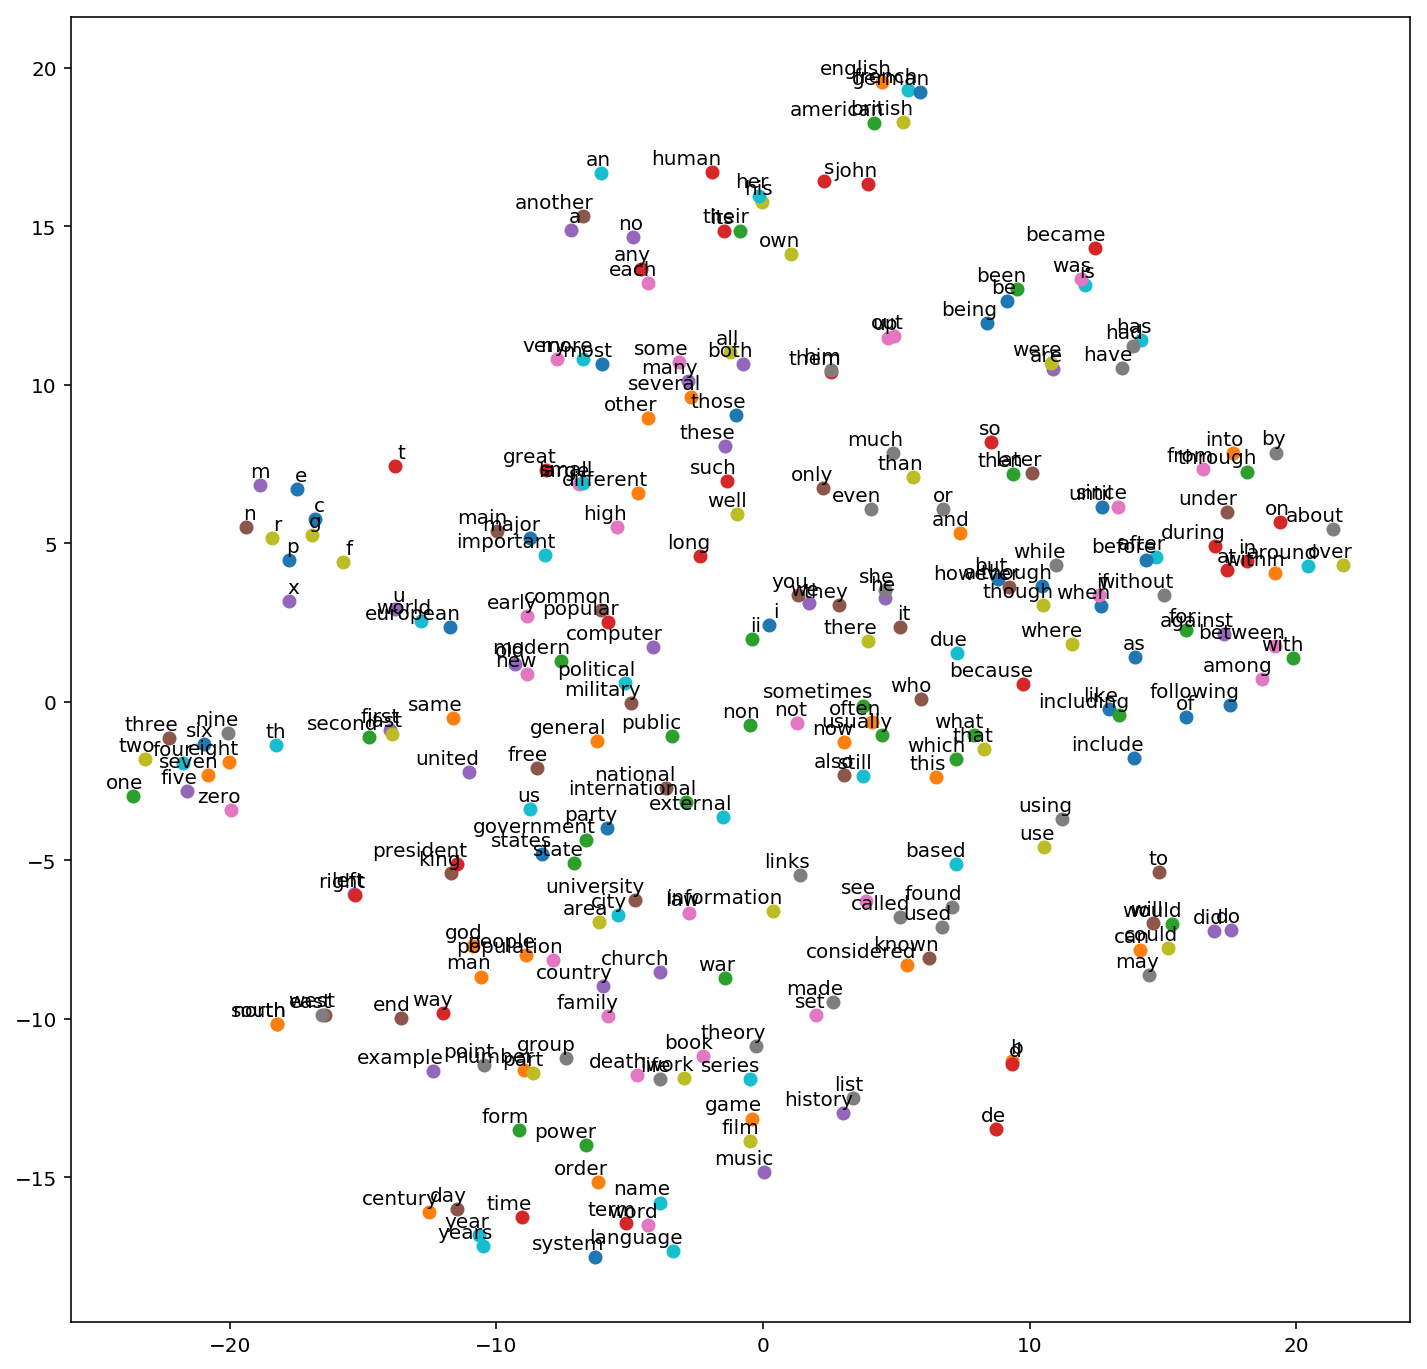

In [30]:
words = [rev_dictionary_[i] for i in range(1, num_points+1)]
cbow_plot(embeddings_2d, words)